**Import**

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

try:
    from google.colab import drive
except:
    pass

**Mounting the drive**

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
filepath = '/content/drive/My Drive/siraj_week4/'

train_dir =  filepath + 'train/'
validation_dir = filepath + 'val/'
test_dir = filepath + 'test/'

In [9]:
#upload my kaggle.json from laptop
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristroger","key":"fbedbea7d64ac3bb7f15600d25f256d5"}'}

In [10]:
#verify if kaggle.json there
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Sep 29 15:30 kaggle.json


In [0]:
# Move The Kaggle API client to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
os.environ['KAGGLE_USERNAME'] = "kristroger"
os.environ['KAGGLE_KEY'] = "fbedbea7d64ac3bb7f15600d25f256d5"

seed(100)
set_random_seed(100)

In [0]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: 
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

**Download dataset**

In [22]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:41<00:00, 40.7MB/s]
100% 2.29G/2.29G [00:41<00:00, 58.9MB/s]
CPU times: user 451 ms, sys: 77.2 ms, total: 528 ms
Wall time: 44.6 s


In [23]:
%time !unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [24]:
%time !unzip chest_xray.zip

unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.
CPU times: user 66.8 ms, sys: 16.6 ms, total: 83.4 ms
Wall time: 3.38 s


In [0]:
os.remove("chest-xray-pneumonia.zip")

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" 

test_dir  = "chest_xray/val/"

In [28]:
search_dir(type="pneumonia", num=10)

person1429_bacteria_3691.jpeg
person899_virus_1553.jpeg
person516_virus_1033.jpeg
person1295_virus_2223.jpeg
person975_virus_1650.jpeg
person760_virus_1388.jpeg
person1666_bacteria_4416.jpeg
person1215_bacteria_3167.jpeg
person1639_bacteria_4347.jpeg
person71_bacteria_347.jpeg


In [29]:
search_dir(type="normal", num=10)

NORMAL2-IM-0815-0001.jpeg
IM-0481-0001.jpeg
NORMAL2-IM-0535-0001-0002.jpeg
IM-0672-0001.jpeg
NORMAL2-IM-1243-0001.jpeg
NORMAL2-IM-0493-0001.jpeg
NORMAL2-IM-0651-0004.jpeg
NORMAL2-IM-1142-0001-0002.jpeg
NORMAL2-IM-1320-0001.jpeg
IM-0543-0001-0002.jpeg


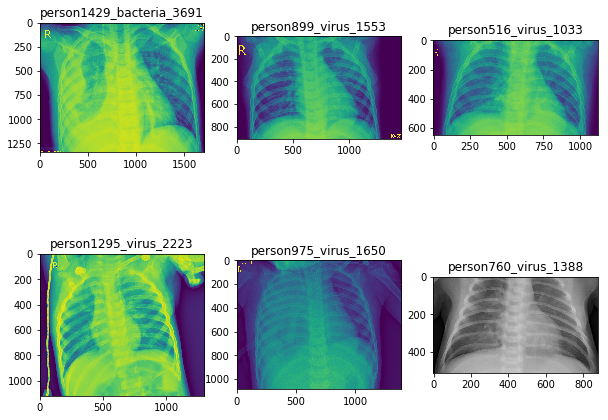

In [30]:
plot_images(type="pneumonia", num=6)

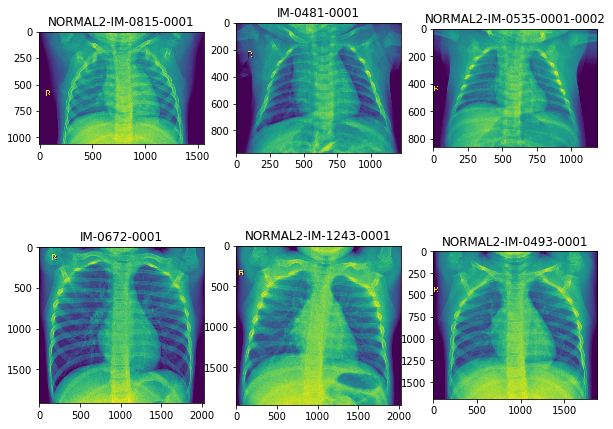

In [31]:
plot_images(type="normal", num=6)

In [32]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

Using TensorFlow backend.


In [33]:
pre_model = InceptionV3(weights='imagenet')









96116736/96112376 [==============================] - 4s 0us/step


In [34]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1)

In [39]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [40]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


In [0]:
import keras

In [43]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

87916544/87910968 [==============================] - 4s 0us/step


In [44]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [45]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
32/32 [==============================] - 382s 12s/step - loss: 0.4896 - acc: 0.8328 - val_loss: 1.5776 - val_acc: 0.7163
Epoch 2/5
32/32 [==============================] - 346s 11s/step - loss: 0.2532 - acc: 0.9059 - val_loss: 2.2159 - val_acc: 0.5753
Epoch 3/5
32/32 [==============================] - 351s 11s/step - loss: 0.2361 - acc: 0.9078 - val_loss: 2.1054 - val_acc: 0.6314
Epoch 4/5
32/32 [==============================] - 349s 11s/step - loss: 0.2175 - acc: 0.9143 - val_loss: 1.4133 - val_acc: 0.6987
Epoch 5/5
32/32 [==============================] - 339s 11s/step - loss: 0.2099 - acc: 0.9151 - val_loss: 1.5352 - val_acc: 0.6907


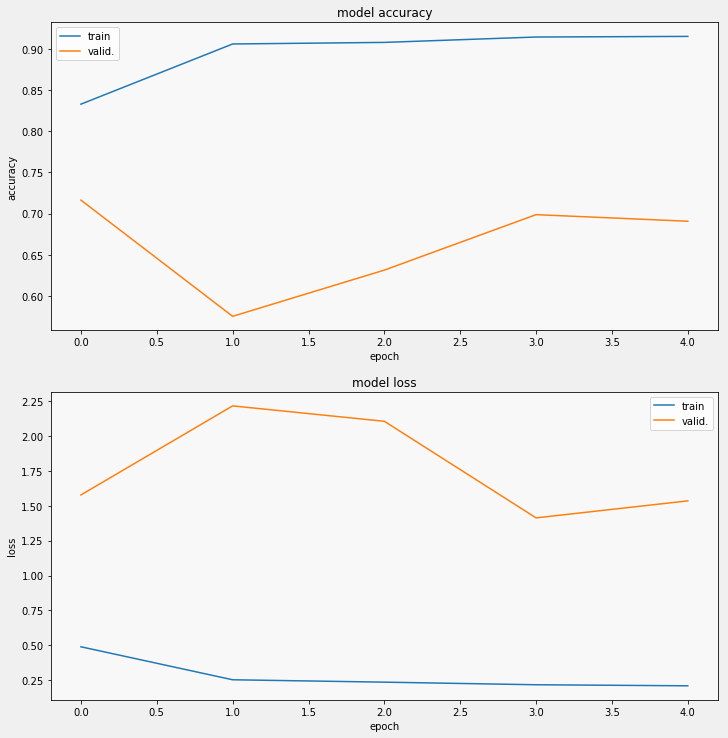

In [46]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [47]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.5634229063896328
Accuracy: 0.75


In [48]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [49]:
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0])

In [50]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

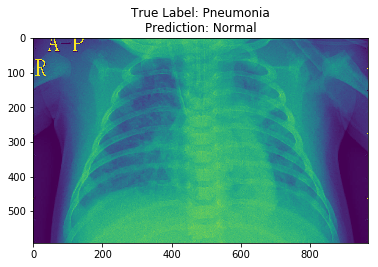

In [51]:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)